In [1]:
import scipy.stats
import numpy as np
import os, sys,  json, math
import matplotlib
# matplotlib.use('Agg')
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import seaborn as sns
plt.style.use(['classic', 'seaborn-deep', 'seaborn-dark'])
sns.set(style='whitegrid')

In [3]:
import models.params as model_params
import models
import attacks
from attacks import params, carlini


steps_num       = 4000
eval_data_size  = 1000

image_size      = 28
n_channels      = 1
num_classes     = 10
relu_leakiness  = 0.0
lrn_rate        = 0.01
lrn_rte_changes = [3000]
lrn_rte_vals    = [0.01]

batch_size = 128
n_draws    = 1


compute_robustness = True

# See doc in ./models/params.py
L = 0.1
hps = models.params.HParams(
    name_prefix="",
    batch_size=batch_size,
    num_classes=num_classes,
    image_size=image_size,
    n_channels=n_channels,
    lrn_rate=lrn_rate,
    lrn_rte_changes=lrn_rte_changes,
    lrn_rte_vals=lrn_rte_vals,
    num_residual_units=4,
    use_bottleneck=False,
    weight_decay_rate=0.0002,
    relu_leakiness=relu_leakiness,
    optimizer='mom',
    image_standardization=False,
    n_draws=n_draws,
    dp_epsilon=1.0,
    dp_delta=0.05,
    robustness_confidence_proba=0.05,
    attack_norm_bound=L,
    attack_norm='l2',
    sensitivity_norm='l2',
    sensitivity_control_scheme='bound',  # bound or optimize
    noise_after_n_layers=1,
    layer_sensitivity_bounds=['l2_l2'],
    noise_after_activation=True,
    parseval_loops=10,
    parseval_step=0.0003,
    steps_num=steps_num,
    eval_data_size=eval_data_size,
)


atk = carlini
attack_params = attacks.params.AttackParams(
    restarts=1,
    n_draws_attack=20,
    n_draws_eval=500,
    attack_norm='l2',
    max_attack_size=5,

    num_examples=1000,

    attack_methodolody=attacks.name_from_module(atk),
    targeted=False,

    sgd_iterations=100,

    use_softmax=True
)


In [4]:
for param, model_attack_params in zip([hps], [[attack_params]]):
#     x = [x/10 for x in range(1,16)]
    print(param)
    print('----')
    print(model_attack_params)
    print('=====')

HParams(name_prefix='', batch_size=128, num_classes=10, lrn_rate=0.01, lrn_rte_changes=[3000], lrn_rte_vals=[0.01], num_residual_units=4, use_bottleneck=False, weight_decay_rate=0.0002, relu_leakiness=0.0, optimizer='mom', image_standardization=False, image_size=28, n_channels=1, n_draws=1, dp_epsilon=1.0, dp_delta=0.05, attack_norm='l2', robustness_confidence_proba=0.05, attack_norm_bound=0.1, sensitivity_norm='l2', sensitivity_control_scheme='bound', noise_after_n_layers=1, layer_sensitivity_bounds=['l2_l2'], noise_after_activation=True, parseval_loops=10, parseval_step=0.0003, steps_num=4000, eval_data_size=1000)
----
[AttackParams(restarts=1, n_draws_attack=20, n_draws_eval=500, attack_norm='l2', max_attack_size=5, num_examples=1000, attack_methodolody='carlini', targeted=False, sgd_iterations=100, use_softmax=True)]
=====


In [5]:
with open ("eval_model/eval_data.json") as f:
    eval_data_base = json.loads(f.read())
    
with open ("eval_model_under_attack/eval_data.json") as f:
    eval_data = json.loads(f.read())

In [37]:
def accuracy(truth, output_sum):
    pred_truth = np.array(truth) == np.argmax(np.array(output_sum), axis=1)
    if len(pred_truth) == 0:
        return 0    
    return sum(pred_truth) / len(pred_truth)

def baselin_acc(eval_data):
    truth  = eval_data['pred_truth']
    output_sum      = eval_data['argmax_sum']
    adv_output_sums = eval_data['adv_argmax_sum']
    
    return  accuracy(truth, output_sum)

def all_y(eval_data, x, curve_y):
    for t in x:
        # The min is in case of multiple restarts
        y = [min(l) > t for l in eval_data['adversarial_norm']]
        curve_y.append(sum(y) / len(y))
    
    return curve_y
#     curves_y.append(curve_y)

<Figure size 432x288 with 0 Axes>

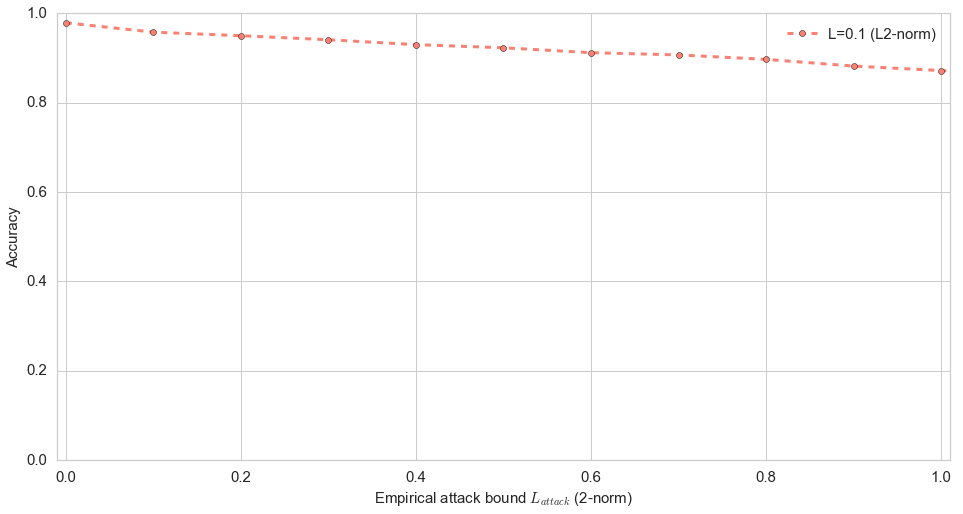

In [69]:
y_list = []
x = [x/10 for x in range(1,16)]

curve_y = [0]
curve_y[0] = baselin_acc(eval_data)
curve_y = all_y(eval_data, x, curve_y)
y_list.append(curve_y)

x = [0] + x  # for the baseline

color_list = ["salmon", "tomato", "r", "darkred"]
marker_list = ['o', '^', '>', 's']

plt.clf()
fig, (ax) = plt.subplots(1, 1, figsize=(16, 8))
x_range=(0, 1)
x_offset = max(x_range)*0.01
plt.xlim((x_range[0]-x_offset, x_range[1]+x_offset))
plt.ylim(0, 1.0)
artists = []

L_list = [0.05, 0.5, 1.0]
curves_labels = []
for i, y in enumerate(curves_y):
    L = param.attack_norm_bound
    label = "L={} (L2-norm)".format(L)
    curves_labels.append(label)
    art, = plt.plot(
        x, y,
        color=color_list[i],
        linestyle='--',
        linewidth=3,
        label=label,
        marker=marker_list[i],
    #         markersize=plots.utils.markersize
    )
    artists.append([None, None, art])
    ax.set(xlabel=r'Empirical attack bound $L_{attack}$ (2-norm)', ylabel=r'Accuracy')

    l = plt.legend(
        handles=[x[2] for x in artists],
        loc=1,
        fontsize=15)
    l.set_zorder(20)  # put the legend on top
    for t in ax.get_xticklabels() + ax.get_yticklabels():
        t.set_fontsize(15)
        
    ax.xaxis.label.set_fontsize(15)
    ax.yaxis.label.set_fontsize(15)

plt.show()